# Basics of BERT

In [1]:
!pip install transformers

In [2]:
import torch
from google.colab import drive
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification,AdamW, BertModel, BertForMaskedLM
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

cuda
1
Tesla K80


In [0]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [0]:
# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

In [6]:
tokenized_text

['[CLS]',
 'Who',
 'was',
 'Jim',
 'He',
 '##nson',
 '?',
 '[SEP]',
 'Jim',
 'He',
 '##nson',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

In [0]:
# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'

In [51]:
tokenizer.convert_tokens_to_ids(['text','aaa','bbb'])

[3087, 100, 100]

In [0]:
# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
indexed_tokens

[101,
 2627,
 1108,
 3104,
 1124,
 15703,
 136,
 102,
 103,
 1124,
 15703,
 1108,
 170,
 16797,
 8284,
 102]

In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [11]:
tokens_tensor

tensor([[  101,  2627,  1108,  3104,  1124, 15703,   136,   102,   103,  1124,
         15703,  1108,   170, 16797,  8284,   102]])

In [12]:
segments_tensors

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]])

# BertModel

In [0]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-cased')

In [0]:
model = model.eval()

In [0]:
# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model = model.to('cuda')


<img src="http://jalammar.github.io/images/bert-output-vector.png" widh="700">

In [0]:
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    # Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]
    
# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)

In [17]:
encoded_layers.shape

torch.Size([1, 16, 768])

In [18]:
len(tokenized_text)

16

In [19]:
model.config.hidden_size

768

<img src="http://jalammar.github.io/images/distilBERT/bert-output-tensor.png" width="600">

# BertForMaskedLM

`bert-base-uncased`: 12-layer, 768-hidden, 12-heads, 110M parameters.
Trained on lower-cased English text.

In [20]:
model.config

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 28996
}

last layer is 768 (number of hidden states) to 30522 (# of vocabulary) FC layer. 

In [0]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model = model.eval()


In [0]:
# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model = model.to('cuda')


In [0]:
# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

In [24]:
predictions.shape # length of sentence * vocabulary size

torch.Size([1, 16, 30522])

<img src="http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png" width="700">

In [0]:
# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

In [26]:
predicted_token

'Who'

Another type of task:

<img src="http://jalammar.github.io/images/bert-next-sentence-prediction.png" width="700">

# Use BERT for classification task

- Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.

reference: 
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

- Another option for classification task: BERT + X
- LSTM

<img src="https://multithreaded.stitchfix.com/assets/posts/2019-07-07-give-me-jeans/bert-arch.png" width="500">

- 1D Conv
<img src="https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/conv.png" width="500">

## Import data

In [0]:
df = pd.read_csv('/content/drive/My Drive/nlp/cola_public/raw/in_domain_train.tsv', 
                 delimiter='\t', 
                 header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [28]:
df.sample(5)

,sentence_source,label,label_notes,sentence
6852,m_02,0,*,Only the best students would he give this book.
3740,ks08,1,NaN,"With their teacher, the kids have arrived safe..."
6247,c_13,1,NaN,Jean wants Robert.
6102,c_13,1,NaN,The policeman kissed the puppy.
2569,l-93,1,NaN,I lifted the books from the floor to the table.


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [30]:
sentences[0]

"[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]"

In [31]:
labels[0]

1

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'Our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


## Pre-process

BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens.
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [36]:
input_ids.shape # num_data * max_len

(8551, 128)

In [37]:
input_ids[0]

array([  101,  3458,  2053,  1281,   112,   189,  4417,  1142,  3622,
         117,  1519,  2041,  1103,  1397,  1141,  1195, 17794,   119,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [55]:
np.array(seq_mask)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
np.array(attention_masks[-1])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
 with an iterator the entire dataset does not need to be loaded into memory

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

## Train Model

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model = model.cuda()

In [44]:
model.classifier

Linear(in_features=768, out_features=2, bias=True)

<img src="http://jalammar.github.io/images/bert-classifier.png" width="700">


In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)[0]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

## Evaluation

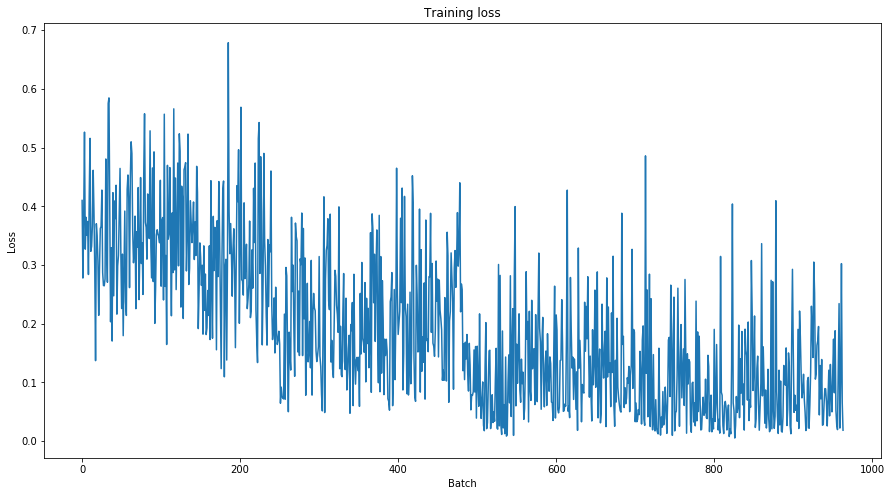

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()